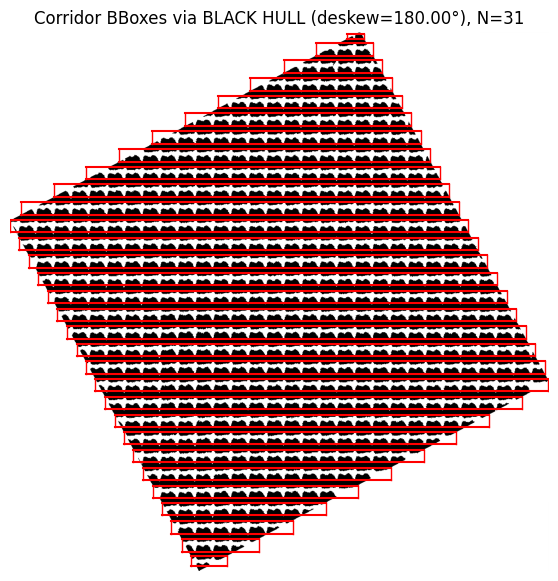

[{'id': 0, 'y0': 3, 'y1': 13, 'x0': 664, 'x1': 698},
 {'id': 1, 'y0': 21, 'y1': 46, 'x0': 603, 'x1': 716},
 {'id': 2, 'y0': 55, 'y1': 80, 'x0': 540, 'x1': 734},
 {'id': 3, 'y0': 90, 'y1': 116, 'x0': 473, 'x1': 753},
 {'id': 4, 'y0': 125, 'y1': 150, 'x0': 410, 'x1': 772},
 {'id': 5, 'y0': 160, 'y1': 185, 'x0': 345, 'x1': 791},
 {'id': 6, 'y0': 195, 'y1': 220, 'x0': 280, 'x1': 810},
 {'id': 7, 'y0': 230, 'y1': 255, 'x0': 215, 'x1': 828},
 {'id': 8, 'y0': 266, 'y1': 290, 'x0': 150, 'x1': 847},
 {'id': 9, 'y0': 300, 'y1': 324, 'x0': 87, 'x1': 866},
 {'id': 10, 'y0': 335, 'y1': 360, 'x0': 21, 'x1': 885},
 {'id': 11, 'y0': 370, 'y1': 394, 'x0': 0, 'x1': 903},
 {'id': 12, 'y0': 405, 'y1': 429, 'x0': 17, 'x1': 922},
 {'id': 13, 'y0': 440, 'y1': 464, 'x0': 36, 'x1': 941},
 {'id': 14, 'y0': 475, 'y1': 499, 'x0': 55, 'x1': 960},
 {'id': 15, 'y0': 510, 'y1': 534, 'x0': 74, 'x1': 979},
 {'id': 16, 'y0': 545, 'y1': 569, 'x0': 93, 'x1': 998},
 {'id': 17, 'y0': 579, 'y1': 604, 'x0': 111, 'x1': 1017},


In [3]:
# Corridor BBoxes via **black convex hull** (white corridors inside the hull).
# This cell:
#   - thresholds image -> black mask
#   - convex hull of black -> content boundary
#   - corridors = (~black) & hull  (white strips bounded by black)
#   - deskews using corridors mask
#   - computes corridor BBoxes **using the hull for extents**
#   - visualizes BBoxes on the deskewed image
#
# You can adjust `row_cov_thresh_rel_hull` if corridors are thinner/thicker.

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, transform, feature
from skimage.transform import hough_line, hough_line_peaks

# ---------------- helpers ----------------
def black_mask(img: np.ndarray):
    if img.ndim == 3:
        gray = color.rgb2gray(img)
    else:
        gray = img.astype(np.float32)
        if gray.max() > 1.0:
            gray = gray / 255.0
    th = filters.threshold_otsu(gray)
    black = gray < th
    return black

def corridors_from_black_hull(img: np.ndarray, tiny_white_px: int = 16):
    blk = black_mask(img)
    hull = morphology.convex_hull_image(blk)
    corridors = (~blk) & hull  # white within hull only
    # clean: remove tiny white specks; fill tiny holes
    corridors = morphology.remove_small_objects(corridors, min_size=tiny_white_px)
    corridors = morphology.remove_small_holes(corridors, area_threshold=64)
    return corridors.astype(np.uint8), hull.astype(np.uint8)

def estimate_rot_from_corridors(mask_white: np.ndarray) -> float:
    edges = feature.canny(mask_white.astype(bool), sigma=2.0)
    h, theta, dist = hough_line(edges)
    _, angles, _ = hough_line_peaks(h, theta, dist, num_peaks=12)
    if len(angles) == 0:
        return 0.0
    # Convert to line orientation; rotate to make horizontal
    phi = angles - np.pi/2.0
    deg = float(np.rad2deg(np.median(phi)))
    return -deg

def deskew_with_hull(img: np.ndarray):
    corr0, hull0 = corridors_from_black_hull(img)
    rot_deg = estimate_rot_from_corridors(corr0)
    img_rot  = transform.rotate(img,  rot_deg, order=1, preserve_range=True).astype(img.dtype)
    corr_rot = transform.rotate(corr0, rot_deg, order=0, preserve_range=True).astype(np.uint8)
    hull_rot = transform.rotate(hull0, rot_deg, order=0, preserve_range=True).astype(np.uint8)
    return img_rot, corr_rot, hull_rot, rot_deg

def detect_corridors_via_hull(corr_mask: np.ndarray,
                              hull_mask: np.ndarray,
                              row_cov_thresh_rel_hull: float = 0.08,
                              min_band_height: int = 5,
                              merge_gap_px: int = 3):
    """
    Corridor y-bands are decided by the fraction of WHITE (corridor) pixels
    relative to the HULL width on that row. This keeps peaks/corners because
    x-extent is taken from the hull, not the corridor mask.
    Returns list of bbox dicts {id, y0, y1, x0, x1}.
    """
    H, W = corr_mask.shape
    hull_width = hull_mask.sum(axis=1).astype(float)
    white_counts = corr_mask.sum(axis=1).astype(float)
    with np.errstate(divide='ignore', invalid='ignore'):
        coverage = np.where(hull_width > 0, white_counts / hull_width, 0.0)

    good = (coverage >= row_cov_thresh_rel_hull).astype(np.uint8)
    if merge_gap_px > 1:
        k = np.ones(merge_gap_px, dtype=int)
        good = (np.convolve(good, k, mode='same') > 0)

    idx = np.flatnonzero(good)
    bboxes = []
    if idx.size:
        starts = [idx[0]]
        ends = []
        for a, b in zip(idx[:-1], idx[1:]):
            if b != a + 1:
                ends.append(a)
                starts.append(b)
        ends.append(idx[-1])

        cid = 0
        for y0, y1 in zip(starts, ends):
            if (y1 - y0 + 1) < min_band_height:
                continue
            # x-extent from the HULL across this band (outer envelope)
            band = hull_mask[y0:y1+1, :]
            x_any = band.any(axis=0)
            if not np.any(x_any):
                continue
            x0 = int(np.argmax(x_any))
            x1 = int(len(x_any) - 1 - np.argmax(x_any[::-1]))
            bboxes.append({'id': cid, 'y0': int(y0), 'y1': int(y1), 'x0': int(x0), 'x1': int(x1)})
            cid += 1
    return bboxes

# ---------------- run & visualize ----------------
img_path = r"C:\Users\sbsas\Documents\uni\Projects\Nikita PhD\res\rotated_best.png"
img = io.imread(img_path)

rot_img, corr_mask, hull_mask, rot_deg = deskew_with_hull(img)
bboxes = detect_corridors_via_hull(
    corr_mask, hull_mask,
    row_cov_thresh_rel_hull=0.07,  # relative to hull width
    min_band_height=5,
    merge_gap_px=3
)

fig = plt.figure(figsize=(7,7))
plt.imshow(rot_img, cmap='gray')

for b in bboxes:
    x0, x1 = b['x0'], b['x1']
    y0, y1 = b['y0'], b['y1']
    # draw rectangle
    plt.plot([x0, x1], [y0, y0], color='red', linewidth=1.5)
    plt.plot([x0, x1], [y1, y1], color='red', linewidth=1.5)
    plt.plot([x0, x0], [y0, y1], color='red', linewidth=1.0)
    plt.plot([x1, x1], [y0, y1], color='red', linewidth=1.0)

plt.title(f"Corridor BBoxes via BLACK HULL (deskew={rot_deg:.2f}°), N={len(bboxes)}")
plt.axis('off')
plt.show()
bboxes


In [14]:
from itertools import cycle
# -------------------- corridor mask via BLACK hull --------------------
def black_mask(img: np.ndarray):
    """
    Create a binary mask of the image using Otsu's thresholding.
    """
    if img.ndim == 3:
        gray = color.rgb2gray(img)
    else:
        gray = img.astype(np.float32)
        if gray.max() > 1.0:
            gray = gray / 255.0
    th = filters.threshold_otsu(gray)
    return (gray < th)

def corridors_from_black_hull(img: np.ndarray, tiny_white_px: int = 16):
    """
    Extract corridors from the black hull mask.
    """
    blk = black_mask(img)
    hull = morphology.convex_hull_image(blk)
    corridors = (~blk) & hull  # white within hull only
    corridors = morphology.remove_small_objects(corridors, min_size=tiny_white_px)
    corridors = morphology.remove_small_holes(corridors, area_threshold=64)
    return corridors.astype(np.uint8), hull.astype(np.uint8)

def estimate_rot_from_corridors(mask_white: np.ndarray) -> float:
    """
    Estimate the rotation angle from the white corridor mask.
    """
    edges = feature.canny(mask_white.astype(bool), sigma=2.0)
    h, theta, dist = transform.hough_line(edges)
    # guard for degenerate case
    try:
        _, angles, _ = hough_line_peaks(h, theta, dist, num_peaks=12)
    except Exception:
        return 0.0
    if len(angles) == 0:
        return 0.0
    phi = angles - np.pi/2.0
    deg = float(np.rad2deg(np.median(phi)))
    return -deg

def deskew_with_hull(img: np.ndarray):
    """
    Deskew the image using the black hull mask.
    """
    corr0, hull0 = corridors_from_black_hull(img)
    rot_deg = estimate_rot_from_corridors(corr0)
    img_rot  = transform.rotate(img,  rot_deg, order=1, preserve_range=True).astype(img.dtype)
    corr_rot = transform.rotate(corr0, rot_deg, order=0, preserve_range=True).astype(np.uint8)
    hull_rot = transform.rotate(hull0, rot_deg, order=0, preserve_range=True).astype(np.uint8)
    return img_rot, corr_rot, hull_rot, rot_deg

# -------------------- detect corridors via hull --------------------
def detect_corridors_via_hull(corr_mask: np.ndarray,
                              hull_mask: np.ndarray,
                              row_cov_thresh_rel_hull: float = 0.07,
                              min_band_height: int = 5,
                              merge_gap_px: int = 3):
    """
    Detect corridors in the given masks.
    """
    H, W = corr_mask.shape
    hull_width = hull_mask.sum(axis=1).astype(float)
    white_counts = corr_mask.sum(axis=1).astype(float)
    with np.errstate(divide='ignore', invalid='ignore'):
        coverage = np.where(hull_width > 0, white_counts / hull_width, 0.0)

    good = (coverage >= row_cov_thresh_rel_hull).astype(np.uint8)
    if merge_gap_px > 1:
        k = np.ones(merge_gap_px, dtype=int)
        good = (np.convolve(good, k, mode='same') > 0)

    idx = np.flatnonzero(good)
    bboxes = []
    if idx.size:
        starts = [idx[0]]; ends = []
        for a, b in zip(idx[:-1], idx[1:]):
            if b != a + 1:
                ends.append(a); starts.append(b)
        ends.append(idx[-1])

        cid = 0
        for y0, y1 in zip(starts, ends):
            if (y1 - y0 + 1) < min_band_height:
                continue
            band = hull_mask[y0:y1+1, :]
            x_any = band.any(axis=0)
            if not np.any(x_any):
                continue
            x0 = int(np.argmax(x_any))
            x1 = int(len(x_any) - 1 - np.argmax(x_any[::-1]))
            bboxes.append({'id': cid, 'y0': int(y0), 'y1': int(y1), 'x0': int(x0), 'x1': int(x1)})
            cid += 1
    return bboxes

# -------------------- deterministic pattern + segments (outer envelope) --------------------
def gen_lines(x0: int, m: int, L: int) -> np.ndarray:
    return x0 + m * np.arange(L, dtype=int)

def segment_outer_envelope(mask_white: np.ndarray, x: int, y0: int, y1: int):
    col = mask_white[y0:y1+1, x]
    ys = np.flatnonzero(col)
    if ys.size == 0:
        return None
    y_top = y0 + int(ys[0])
    y_bot = y0 + int(ys[-1])
    if y_bot < y_top:
        return None
    return (x, y_top, y_bot)

def window_segments(mask_white: np.ndarray, corridor: dict,
                    x0: int, m: int, L: int, L_min: int):
    xs = gen_lines(x0, m, L)
    segs = []
    for x in xs:
        if x < corridor['x0'] or x > corridor['x1']:
            break
        seg = segment_outer_envelope(mask_white, x, corridor['y0'], corridor['y1'])
        if seg is None:
            break  # interrupt at first empty column
        segs.append(seg)
    if len(segs) < L_min:
        return None
    return segs

def descriptor_from_segments(segments):
    xs = [s[0] for s in segments]
    y_top = [s[1] for s in segments]
    y_bot = [s[2] for s in segments]
    w = [b - t for t, b in zip(y_top, y_bot)]
    order = np.argsort(xs)
    return {
        "x": np.asarray(xs, int)[order],
        "y_top": np.asarray(y_top, int)[order],
        "y_bot": np.asarray(y_bot, int)[order],
        "w": np.asarray(w, int)[order],
    }

def match_segments_to_descriptor(segments, ref_desc,
                                 tau_abs=2, alpha=0.05, beta=0.20,
                                 L_min=12, S_min=0.80):
    if segments is None or len(segments) == 0 or ref_desc is None:
        return {"matched": False, "dy": 0, "score": 0.0}
    obs = descriptor_from_segments(segments)
    n = min(len(obs["x"]), len(ref_desc["x"]))
    if n == 0:
        return {"matched": False, "dy": 0, "score": 0.0}
    dy = int(np.median(obs["y_top"][:n] - ref_desc["y_top"][:n]))
    ref_w = ref_desc["w"][:n]
    tau_pos = np.maximum(tau_abs, (alpha * np.maximum(1, ref_w)))
    tau_w   = np.maximum(1, (beta * np.maximum(1, ref_w)))
    top_err = np.abs(obs["y_top"][:n] - (ref_desc["y_top"][:n] + dy))
    bot_err = np.abs(obs["y_bot"][:n] - (ref_desc["y_bot"][:n] + dy))
    w_err   = np.abs(obs["w"][:n]     -  ref_w)
    accept = (top_err <= tau_pos) & (bot_err <= tau_pos) & (w_err <= tau_w)
    score = float(accept.mean()) if n > 0 else 0.0
    matched = (accept.sum() >= L_min) and (score >= S_min)
    return {"matched": matched, "dy": dy, "score": score}

def slide_windows_with_matching(mask_white: np.ndarray, corridor: dict,
                                ref_desc, m=4, L=20, stride=4, L_min=12,
                                tau_abs=2, alpha=0.05, beta=0.20, S_min=0.80):
    regions = []
    x_start = corridor['x0']
    x_last  = corridor['x1'] - (L - 1) * m
    rid = 0
    while x_start <= x_last:
        segs = window_segments(mask_white, corridor, x_start, m, L, L_min)
        if segs is not None:
            res = match_segments_to_descriptor(segs, ref_desc,
                                               tau_abs=tau_abs, alpha=alpha, beta=beta,
                                               L_min=L_min, S_min=S_min)
            regions.append({
                'region_id': rid,
                'corridor_id': corridor['id'],
                'x0': x_start,
                'segments': segs,
                'matched': res["matched"],
                'dy': res["dy"],
                'score': res["score"],
            })
            rid += 1
        x_start += stride
    return regions

# -------------------- run on your image --------------------


rot_img, corr_mask, hull_mask, rot_deg = deskew_with_hull(img)
corridors = detect_corridors_via_hull(corr_mask, hull_mask,
                                      row_cov_thresh_rel_hull=0.07,
                                      min_band_height=5, merge_gap_px=3)

# pick the middle corridor by y-center
centers = [0.5*(c['y0'] + c['y1']) for c in corridors]
mid_idx = int(np.argsort(centers)[len(centers)//2])
mid_corr = corridors[mid_idx]

# build a reference pattern that **starts in the middle** of that corridor

# old parameters: 4 pixels spacing, 20 lines, stride 4, min len 12

m, L, stride, L_min = 2, 10, 1, 8 # spacing, length, stride, min len


x_mid = int(0.5 * (mid_corr['x0'] + mid_corr['x1']))
x0_ref = min(x_mid, mid_corr['x1'] - (L-1)*m)  # start at middle, clamp if needed
ref_segs = window_segments(corr_mask, mid_corr, x0_ref, m, L, L_min)
ref_desc = descriptor_from_segments(ref_segs) if ref_segs is not None else None

# slide and match on all corridors
all_windows = []
for c in corridors:
    regs = slide_windows_with_matching(corr_mask, c, ref_desc,
                                       m=m, L=L, stride=stride, L_min=L_min,
                                       tau_abs=2, alpha=0.05, beta=0.20, S_min=0.80)
    all_windows.extend(regs)

matched_count = sum(r['matched'] for r in all_windows)

print(f"Deskew rotation: {rot_deg:.2f}°")
print(f"Detected corridors: {len(corridors)}")
print(f"Reference corridor id: {mid_corr['id']}, x0_ref={x0_ref}, m={m}, L={L}")
print(f"Total windows evaluated: {len(all_windows)}, matched: {matched_count}")


Deskew rotation: 180.00°
Detected corridors: 31
Reference corridor id: 15, x0_ref=526, m=2, L=10
Total windows evaluated: 17512, matched: 779


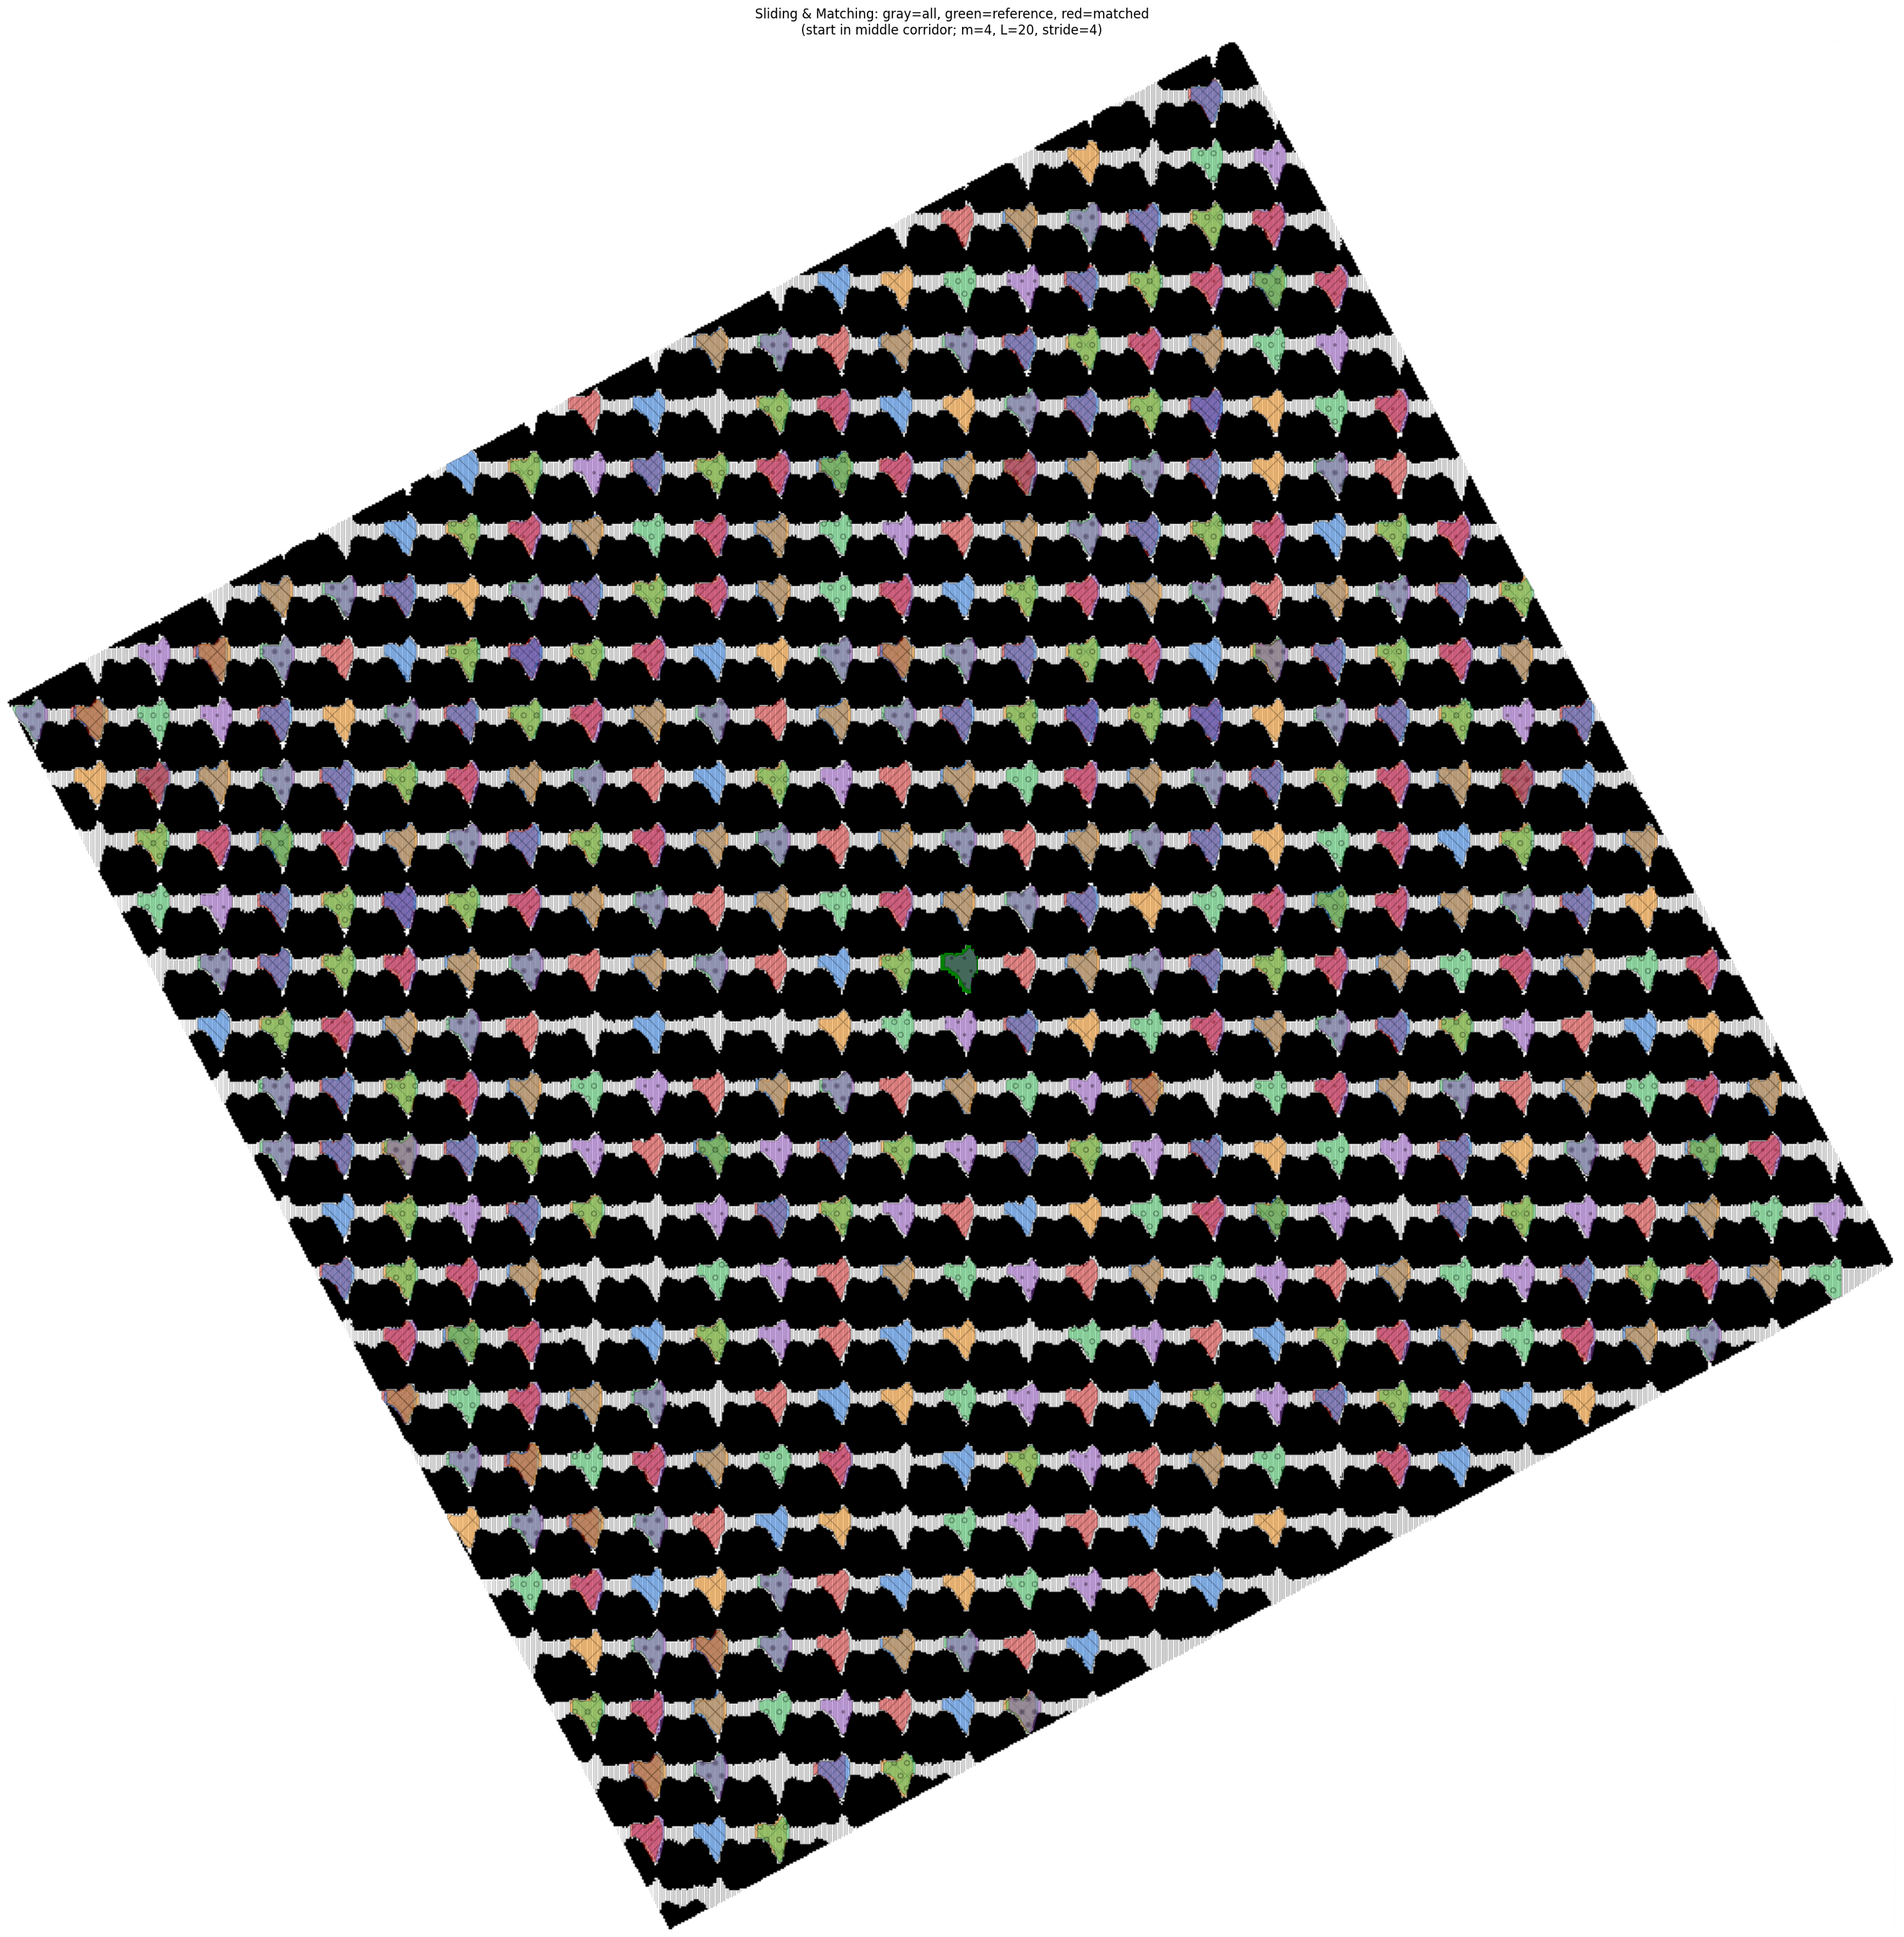

In [15]:
matched_windows = [R for R in all_windows if R['matched']]

# Helper: build a polygon (x,y) for a window's band from its segments
def window_polygon(segments, jitter=0.0):
    # segments: list of (x, y_top, y_bot)
    segs = sorted(segments, key=lambda s: s[0])
    xs  = np.array([s[0] for s in segs], dtype=float) + jitter
    yt  = np.array([s[1] for s in segs], dtype=float)
    yb  = np.array([s[2] for s in segs], dtype=float)
    # polygon goes along top left->right, then bottom right->left
    x_poly = np.concatenate([xs, xs[::-1]])
    y_poly = np.concatenate([yt, yb[::-1]])
    return x_poly, y_poly

# -------------------- Visualization --------------------
palette = cycle([
    (0.90, 0.10, 0.10, 0.45),  # red
    (0.10, 0.48, 0.95, 0.45),  # blue
    (1.00, 0.55, 0.00, 0.45),  # orange
    (0.20, 0.80, 0.35, 0.45),  # green
    (0.60, 0.30, 0.80, 0.45),  # purple
])

hatch_cycle = cycle(['///', '\\\\', 'x', 'o', '.'])

# Small jitter so perfectly aligned bands separate a bit
max_jitter = 1.0
jitters = [((i % 5) - 2) / 2.0 * max_jitter for i in range(len(matched_windows))]

fig = plt.figure(figsize=(32, 32))
plt.imshow(rot_img, cmap='gray')

# all candidate window lines (light gray)
for R in all_windows:
    for (x, y_top, y_bot) in R['segments']:
        plt.plot([x, x], [y_top, y_bot], color=(0.7, 0.7, 0.7, 0.25), linewidth=0.8)

# reference pattern (green)
if ref_segs is not None:
    for (x, y_top, y_bot) in ref_segs:
        plt.plot([x, x], [y_top, y_bot], color='green', linewidth=5)

# # matched windows (red)
# for R in all_windows:
#     if R['matched']:
#         for (x, y_top, y_bot) in R['segments']:
#             plt.plot([x, x], [y_top, y_bot], color='red', linewidth=1.2)

# # matched windows (alternating colors, semi-transparent)
# color_for_window = {}
# for i, R in enumerate(all_windows):
#     if R['matched']:
#         # one color per matched window
#         col = color_for_window.setdefault(i, next(palette))
#         for (x, y_top, y_bot) in R['segments']:
#             plt.plot([x, x], [y_top, y_bot], color=col, linewidth=1.6)

# Draw each matched window as a translucent, hatched band
for i, R in enumerate(matched_windows):
    col = next(palette)
    hatch = next(hatch_cycle)
    x_poly, y_poly = window_polygon(R['segments'], jitter=jitters[i])
    plt.fill(x_poly, y_poly, facecolor=col, edgecolor=(0,0,0,0.25),
             linewidth=0.8, hatch=hatch, zorder=2)

plt.title("Sliding & Matching: gray=all, green=reference, red=matched\n"
          f"(start in middle corridor; m=4, L=20, stride=4)")
plt.axis('off')
plt.show()

In [ ]:
from scipy import ndimage as ndi
from skimage import filters as skfilters
# load
path = r"C:\Users\sbsas\Documents\uni\Projects\Nikita PhD\res\mask_original.png"
img = io.imread(path)
if img.ndim == 3:
    img_rgb = img[..., :3] if img.shape[2] == 4 else img
    gray = color.rgb2gray(img_rgb)
else:
    gray = img.astype(float)
    if gray.max() > 1.0: gray = gray / 255.0

th = filters.threshold_otsu(gray)
mask_white = (gray >= th).astype(np.uint8)

# corridors (simple)
def detect_corridors_simple(mask_white, row_cov_thresh=0.12, min_band_height=4):
    H, W = mask_white.shape
    coverage = mask_white.sum(axis=1) / float(max(1, W))
    good = (coverage >= row_cov_thresh).astype(np.uint8)
    idx = np.flatnonzero(good)
    out = []
    if idx.size:
        starts = [idx[0]]; ends = []
        for a, b in zip(idx[:-1], idx[1:]):
            if b != a + 1:
                ends.append(a); starts.append(b)
        ends.append(idx[-1])
        cid = 0
        for y0, y1 in zip(starts, ends):
            if (y1 - y0 + 1) < min_band_height: continue
            band = mask_white[y0:y1+1, :]
            x_any = band.any(axis=0)
            if not np.any(x_any): continue
            x0 = int(np.argmax(x_any)); x1 = int(len(x_any)-1 - np.argmax(x_any[::-1]))
            out.append({'id': cid, 'y0': int(y0), 'y1': int(y1), 'x0': int(x0), 'x1': int(x1)})
            cid += 1
    return out

corridors = detect_corridors_simple(mask_white)

# method (1)
def corridor_envelopes(mask_white, y0, y1, x0, x1):
    band = mask_white[y0:y1+1, x0:x1+1].astype(bool)
    H, W = band.shape
    T = np.full(W, np.nan, dtype=float); B = np.full(W, np.nan, dtype=float)
    cols_any = band.any(axis=0)
    if cols_any.any():
        idx = np.where(cols_any)[0]
        first = np.argmax(band[:, idx], axis=0)
        last  = (H-1) - np.argmax(band[::-1, idx], axis=0)
        T[idx] = y0 + first; B[idx] = y0 + last
    return T, B

def smooth_1d(arr, win_med=5, win_mean=9):
    a = arr.astype(float).copy()
    x = np.arange(a.size); good = ~np.isnan(a)
    if good.sum() < 2: return arr
    a[~good] = np.interp(x[~good], x[good], a[good])
    if win_med > 1:
        k = win_med//2; pad = np.pad(a, (k,k), mode='edge')
        a = np.array([np.median(pad[i:i+2*k+1]) for i in range(a.size)])
    if win_mean > 1:
        k = win_mean//2; ker = np.ones(2*k+1) / (2*k+1)
        a = np.convolve(a, ker, mode='same')
    return a

def rebuild_corridor(mask_shape, T_s, B_s, x0, x1):
    H, W = mask_shape
    out = np.zeros(mask_shape, dtype=np.uint8)
    xs = np.arange(x0, x1+1)
    yt = np.clip(np.rint(T_s).astype(int), 0, H-1)
    yb = np.clip(np.rint(B_s).astype(int), 0, H-1)
    for x, t, b in zip(xs, yt, yb):
        if b >= t: out[t:b+1, x] = 1
    return out

def smooth_mask_by_profiles(mask_white, corridors, win_med=5, win_mean=9):
    H, W = mask_white.shape; out = np.zeros_like(mask_white, dtype=np.uint8)
    for c in corridors:
        T, B = corridor_envelopes(mask_white, c['y0'], c['y1'], c['x0'], c['x1'])
        if np.all(np.isnan(T)) or np.all(np.isnan(B)): continue
        Ts = smooth_1d(T, win_med=win_med, win_mean=win_mean)
        Bs = smooth_1d(B, win_med=win_med, win_mean=win_mean)
        out |= rebuild_corridor((H, W), Ts, Bs, c['x0'], c['x1'])
    return out

mask_profile = smooth_mask_by_profiles(mask_white, corridors)

# method (2)
def smooth_mask_morph(mask_white, horiz_close=(3,9), disk_open=1, fill_holes_area=64):
    m = mask_white.astype(bool)
    if fill_holes_area: m = morphology.remove_small_holes(m, area_threshold=fill_holes_area)
    if horiz_close:
        se = morphology.rectangle(horiz_close[0], horiz_close[1])
        m = morphology.closing(m, footprint=se)
    if disk_open and disk_open > 0:
        se2 = morphology.disk(disk_open)
        m = morphology.opening(m, footprint=se2)
    return m.astype(np.uint8)

mask_morph = smooth_mask_morph(mask_white)

# method (3) preferred
def smooth_mask_sdf(mask_white, sigma=1.6):
    m = mask_white.astype(bool)
    din  = ndi.distance_transform_edt(m); dout = ndi.distance_transform_edt(~m)
    sdf = din - dout; sdf_s = skfilters.gaussian(sdf, sigma=sigma, preserve_range=True)
    return (sdf_s > 0).astype(np.uint8)

mask_sdf = smooth_mask_sdf(mask_white)

# display
plt.figure(figsize=(7,5)); plt.imshow(mask_white);   plt.title("Original binary mask"); plt.axis('off'); plt.show()
plt.figure(figsize=(7,5)); plt.imshow(mask_profile); plt.title("Smoothing (1): Corridor-aware");      plt.axis('off'); plt.show()
plt.figure(figsize=(7,5)); plt.imshow(mask_morph);   plt.title("Smoothing (2): Morphological");       plt.axis('off'); plt.show()
plt.figure(figsize=(7,5)); plt.imshow(mask_sdf);     plt.title("Smoothing (3): SDF");                 plt.axis('off'); plt.show()
